In [ ]:
!pip3 install torch torchvision torchaudio

In [22]:
from torch import nn, optim, no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from matplotlib.pyplot import imshow
from time import time
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
MNIST_treino = datasets.MNIST('./', train = True, transform = transforms.ToTensor(), download=True)
MNIST_teste =  datasets.MNIST('./', train = False, transform = transforms.ToTensor(), download=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 23732812.91it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 79173656.09it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25955292.08it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13075174.17it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# Nova secção

In [ ]:
print(len(MNIST_treino), len(MNIST_teste))

In [ ]:
type(MNIST_teste)

In [ ]:
MNIST_teste[0]

In [ ]:
type(MNIST_teste[0])

In [ ]:
type(MNIST_teste[0][0])

In [ ]:
len(MNIST_teste[0][0])

In [ ]:
MNIST_teste[0][0]

In [ ]:
MNIST_teste[0][0][0].shape

In [ ]:
MNIST_teste[0][0][0].shape[0]

In [ ]:
MNIST_teste[0][0][0].shape[0] * MNIST_teste[0][0][0].shape[1]

3


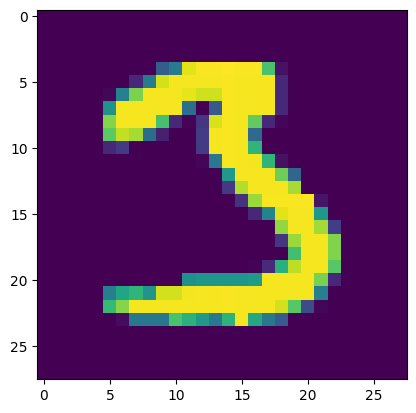

In [ ]:
imagem, rotulo = MNIST_treino[11111]

imshow(imagem[0])
print(rotulo)

In [ ]:
args = {
    'batch_size':       5,    #quantidade de amostras por iteração
    'num_threads':      4,    #número de threads do DataLoader
    #número real de batches = 20 (tamanho de cada batch * quantidade de threads)
    'num_classes':      len(MNIST_teste.classes),
    'taxa_aprendizado': 1e-4, #
    'weight_decay':     5e-4, #
    'num_epochs':       30    #
}
neurons = {
    'input_size':   1 * 28 * 28, #dimensão de entrada (imagens de 28x28 bits com 1 canal de cor. precisa ser achatado para uma única dimensão)
    'hidden_size':  128, # dimensão escondida, hiperparâmetro
    'out_size':     args['num_classes']
}

In [ ]:
treino_loader = DataLoader(MNIST_treino,
                          batch_size = args['batch_size'],
                          shuffle = True,
                          num_workers = args['num_threads'])

teste_loader = DataLoader(MNIST_teste,
                          batch_size = args['batch_size'],
                          shuffle = True,
                          num_workers = args['num_threads'])


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
class MNIST_MLP(nn.Module):
  #Definição da nossa própria multi-layered perceptron
  def __init__(self, input_size, hidden_size, out_size):
    super(MNIST_MLP, self).__init__()

    #Definição das camadas e das funções de ativação intermediárias
    # aqui escolhemos duas redes lineares e como funções de ativação, ReLU duas vezes
    self.features  = nn.Sequential(
                        nn.Linear(input_size, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, hidden_size),
                        nn.ReLU())
    #A de saída também será linear
    self.out     = nn.Linear(hidden_size, out_size)
    self.softmax = nn.Softmax()
    #Como estamos lidando com um processo de classificação, passaremos por um softmax

  def forward(self, input):
    #Define a computação de cada chamada
    input = input.view(input.size(0), -1) #Linearizando a entrada

    feature = self.features(input)
    output  = self.softmax(self.out(feature))

    return output


In [ ]:
rede = MNIST_MLP(neurons['input_size'], neurons['hidden_size'], neurons['out_size'])

In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam(rede.parameters(), lr=args['taxa_aprendizado'], weight_decay=args['weight_decay'])
#Pesquisar sobre pq Adam (sei leigamente que é mt bom)

In [ ]:
def treina(train_set, rede, num_epochs):
  rede.train() #modo treino

  for epoch in range(num_epochs):
    start = time()

    epoch_loss = []
    for batch in train_set:

      dado, rotulo = batch

      # Forward
      pred = rede(dado)
      loss = criterion(pred, rotulo) #CrossEntropy indicado para classificação multiclasses
      epoch_loss.append(loss.item())

      # Backward
      loss.backward()
      optimizer.step()

    epoch_loss = np.asarray(epoch_loss)
    end = time()

    print("Epoca %d, Loss: %.4f +\- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

    return epoch_loss.mean()


In [ ]:
def valida(teste_set, rede, num_epochs):
  rede.eval() #modo avaliação

  for epoch in range(num_epochs):
    start = time()

    epoch_loss = []
    y_true = []
    y_pred = []

    with no_grad():

      for batch in teste_set:

        dado, rotulo = batch

        # Forward
        pred = rede(dado)
        loss = criterion(pred, rotulo) #CrossEntropy indicado para classificação multiclasses
        epoch_loss.append(loss.item())

        y_true.extend(rotulo)
        y_pred.extend(pred)

    epoch_loss = np.asarray(epoch_loss)
    mse = MSE(y_true, y_pred)
    mae = MAE(y_true, y_pred)
    end = time()

    print("Epoca %d, Loss: %.4f +\- %.4f, Tempo: %.2f" % (epoch, epoch_loss.mean(), epoch_loss.std(), end-start))

    return epoch_loss.mean(), mse, mae

In [23]:
treino_loss, teste_loss, mse_loss, mae_loss = [], [], [], []
for epoch in range(args['num_epochs']):

  # Train
  treino_loss.append(treina(treino_loader, rede, args['num_epochs']))

  # Validate
  teste_loss.append(valida(teste_loader, rede, args['num_epochs'][0]))

  mse_loss.append(valida(teste_loader, rede, args['num_epochs'][1]))

  mae_loss.append(valida(teste_loader, rede, args['num_epochs'][2]))



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


KeyboardInterrupt: ignored